# Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Text Cleaning
import re
import nltk

# Importing the dataset

In [2]:
dataset = pd.read_csv("cyberbullying_tweets.csv")
y = dataset.iloc[:, -1].values
y = np.array([0 if x == "not_cyberbullying" else 1 for x in y])
dataset["cyberbullying_type"] = y

# Summarizing the dataset

In [3]:
print(dataset.shape)

(47692, 2)


In [4]:
print(dataset.head(10))

                                          tweet_text  cyberbullying_type
0  In other words #katandandre, your food was cra...                   0
1  Why is #aussietv so white? #MKR #theblock #ImA...                   0
2  @XochitlSuckkks a classy whore? Or more red ve...                   0
3  @Jason_Gio meh. :P  thanks for the heads up, b...                   0
4  @RudhoeEnglish This is an ISIS account pretend...                   0
5  @Raja5aab @Quickieleaks Yes, the test of god i...                   0
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...                   0
7  Karma. I hope it bites Kat on the butt. She is...                   0
8       @stockputout everything but mostly my priest                   0
9  Rebecca Black Drops Out of School Due to Bully...                   0


In [5]:
print(dataset.columns)

Index(['tweet_text', 'cyberbullying_type'], dtype='object')


In [6]:
print(dataset.groupby("cyberbullying_type").count())

                    tweet_text
cyberbullying_type            
0                         7945
1                        39747


# Preprocessing the data

In [7]:
dataset.duplicated().sum()
dataset = dataset[~dataset.duplicated()]

## Stopwords issue

In [8]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


# Text Cleaning

In [9]:
corpus = []
size = dataset.shape[0]
all_stopwords = stopwords.words('english')
for i in range(size):
    text = dataset.iloc[i,0]
    tweet = text.lower()
    tweet = tweet.split()
    tweet = [re.sub("(https?\://\S+)"," ", w) for w in tweet]
    tweet = [re.sub("^@\S+", " ", w) for w in tweet]
    tweet = [re.sub('[^\x00-\x7f]'," ", w) for w in tweet]
    tweet = [re.sub('^#\S+'," ", w) for w in tweet]
    tweet = " ".join(tweet)
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    tweet = re.sub("\s+", " ", tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if word not in set(all_stopwords)]
    tweet = " ".join(tweet)
    corpus.append(tweet)

# Bag of Words Model

In [10]:
# Considering the top 20000 words ordered by their frequency across the corpus
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 20000)  
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, -1].values

# Data Visualisation

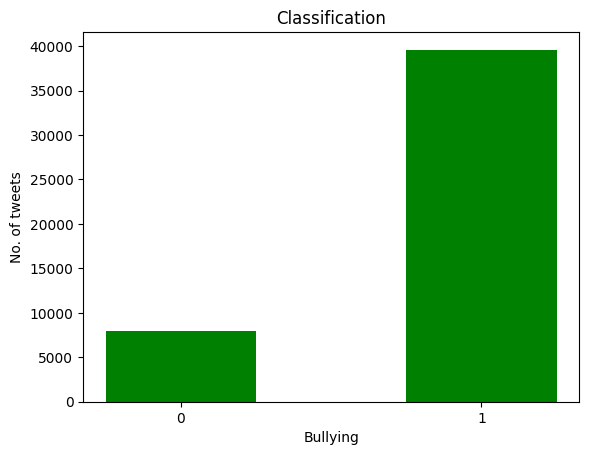

In [11]:
bullying = ["0", "1"]
count = dataset.groupby("cyberbullying_type").count()["tweet_text"]
plt.bar(bullying, count, color = "green", width = 0.5)
plt.title("Classification")
plt.xlabel("Bullying")
plt.ylabel("No. of tweets")
plt.show()

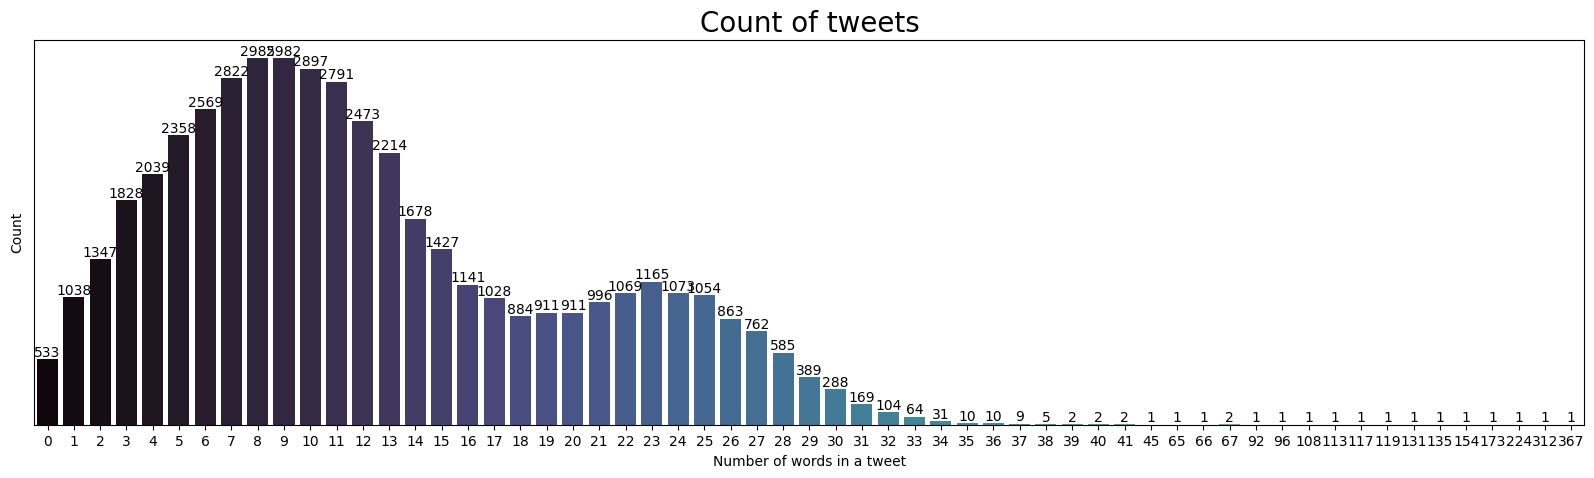

In [12]:
tweet_len = np.array(X.sum(axis = 1))
df = pd.DataFrame(tweet_len)
df.rename(columns = {0:"text_len"}, inplace = True)

plt.figure(figsize = (20,5))
ax = sns.countplot(x = 'text_len',data = df, palette = 'mako')
plt.title('Count of tweets', fontsize = 20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Number of words in a tweet')
plt.show()

# Splitting the dataset into training set and test set

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Training the Naive Bayes model on the Training set

In [14]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB(var_smoothing = 1e-6)
classifier.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-06)

# Predicting the Test set results

In [15]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 1]
 [1 1]
 ...
 [1 1]
 [1 1]
 [0 1]]


# Making the Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
print("Accuracy: ", round(accuracy_score(y_test, y_pred),2))
print("Precision: ", round(precision_score(y_test, y_pred),2))
print("Recall: ", round(recall_score(y_test, y_pred),2))
print("F1 Score: ", round(f1_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

Accuracy:  0.63
Precision:  0.92
Recall:  0.61
F1 Score:  0.74
              precision    recall  f1-score   support

           0       0.27      0.73      0.39      1931
           1       0.92      0.61      0.74      9951

    accuracy                           0.63     11882
   macro avg       0.59      0.67      0.56     11882
weighted avg       0.81      0.63      0.68     11882



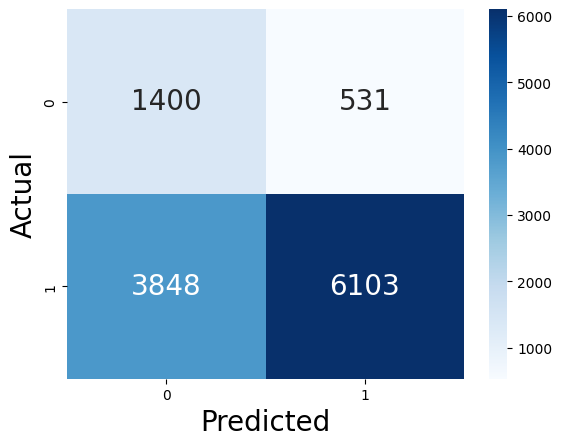

In [17]:
ax = sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='Blues',fmt='g', annot_kws={"size":20})
ax.set_ylabel('Actual',fontsize=20)
ax.set_xlabel('Predicted',fontsize=20)
plt.show()

# Cross - Validation

In [18]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 3)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 65.69 %
Standard Deviation: 0.20 %


# Training the Multinomial Naive Bayes model on the Training set

In [19]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB(alpha = 0.01)
nb_clf.fit(X_train,y_train)
nb_pred = nb_clf.predict(X_test)
print(np.concatenate((nb_pred.reshape(len(nb_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [1 1]
 ...
 [1 1]
 [1 1]
 [1 1]]


# Making the Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
print("Accuracy: ", round(accuracy_score(y_test, nb_pred),2))
print("Precision: ", round(precision_score(y_test, nb_pred),2))
print("Recall: ", round(recall_score(y_test, nb_pred),2))
print("F1 Score: ", round(f1_score(y_test, nb_pred),2))
print(classification_report(y_test, nb_pred))

Accuracy:  0.84
Precision:  0.89
Recall:  0.92
F1 Score:  0.9
              precision    recall  f1-score   support

           0       0.50      0.42      0.45      1931
           1       0.89      0.92      0.90      9951

    accuracy                           0.84     11882
   macro avg       0.69      0.67      0.68     11882
weighted avg       0.83      0.84      0.83     11882



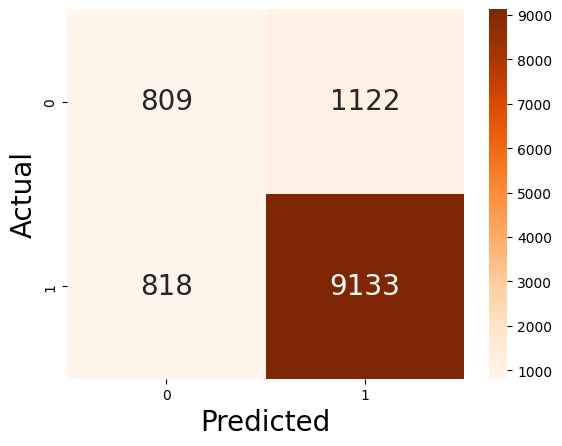

In [21]:
ax = sns.heatmap(confusion_matrix(y_test,nb_pred),annot=True,cmap='Oranges',fmt='g', annot_kws={"size":20})
ax.set_ylabel('Actual',fontsize=20)
ax.set_xlabel('Predicted',fontsize=20)
plt.show()

# Cross - Validation

In [22]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = nb_clf, X = X_train, y = y_train, cv = 3)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 83.38 %
Standard Deviation: 0.07 %
